In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import piecewise_regression
import statsmodels.api as sm

from utils.plotting import regplot_lowess_ci

dms_df = pd.read_csv("output/mutations/data.csv")
len(dms_df)

4400

In [2]:
query_str="(single_nt == True) & (WT == False)"
data = dms_df.query(query_str).dropna()
len(data)

1214

Here's the piecewise regression setup we had before:

In [3]:
def do_piecewise_regression(measured_var, n_breakpoints):
    delta_thing = data[f"delta_{measured_var}"].to_numpy()
    enrichment = data["mutation enrichment"].to_numpy()

    if n_breakpoints is None:
        ms = piecewise_regression.ModelSelection(delta_thing, enrichment, max_breakpoints=5)
        return ms
    #else:
    pw_fit = piecewise_regression.Fit(delta_thing, enrichment, n_breakpoints=n_breakpoints)

    pw_fit.plot_data(color="grey", alpha=0.5)
    pw_fit.plot_fit(color="red", linewidth=4)
    pw_fit.plot_breakpoints()
    pw_fit.plot_breakpoint_confidence_intervals()
    pw_fit.summary()
    plt.xlabel("$\Delta$ affinity")
    plt.ylabel("mutation enrichment")
    plt.show()
    plt.close()
    return pw_fit

And we do the same PW regression as before, with the same result. Note that we get `p=7.93105e-08` for the existence of at least one breakpoint.


                    Breakpoint Regression Results                     
No. Observations                     1214
No. Model Parameters                    4
Degrees of Freedom                   1210
Res. Sum of Squares               292.615
Total Sum of Squares              403.105
R Squared                        0.274098
Adjusted R Squared               0.271696
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -1.03333       0.0741      -13.947      4.17e-41      -1.1787     -0.88796
alpha1            -0.0931372       0.0551      -1.6917         0.091     -0.20115     0.014876
beta1                1.24953        0.095       13.153             -       1.0631       1.4359
breakpoint1        -0.539252       0.0533            -             -     -0.64378     -0.43472
-----------------

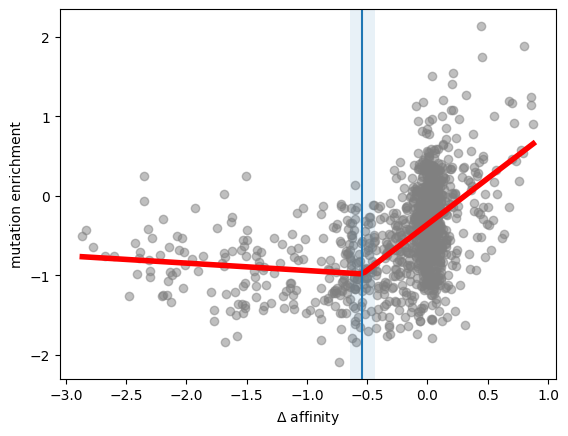

In [4]:
pw_fit = do_piecewise_regression("bind_CGG", 1)

OK, let's look at the residual of delta affinity now. No signal, as expected given than we are plotting the residual:

<Axes: xlabel='delta_bind_CGG', ylabel='enrichment affinity residual'>

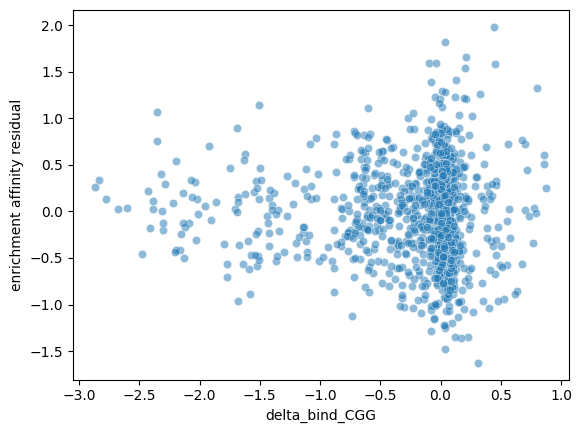

In [5]:
predicted_values = pw_fit.predict(data['delta_bind_CGG'].values)
data['enrichment affinity residual'] = data['mutation enrichment'] - predicted_values

# Plot the residuals 
sns.scatterplot(data=data, x='delta_bind_CGG', y='enrichment affinity residual', alpha=0.5)

Now let's look at the influence of the residual.

Text(0, 0.5, 'enrichment affinity residual')

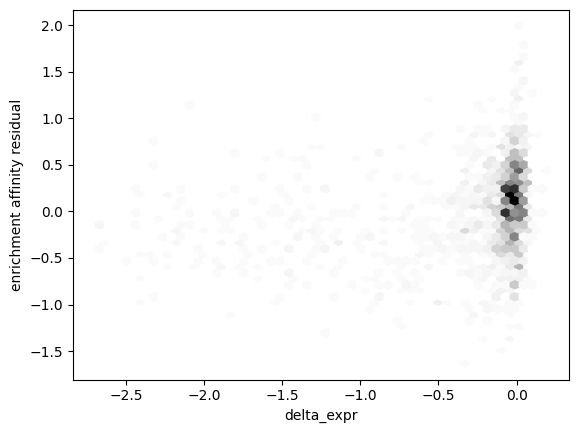

In [6]:
plt.figure()
plt.hexbin(data['delta_expr'], data['enrichment affinity residual'], gridsize=50, cmap='Greys')
plt.xlabel('delta_expr')
plt.ylabel('enrichment affinity residual')

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0603      0.016      3.851      0.000       0.030       0.091
delta_expr     0.1951      0.024      8.028      0.000       0.147       0.243


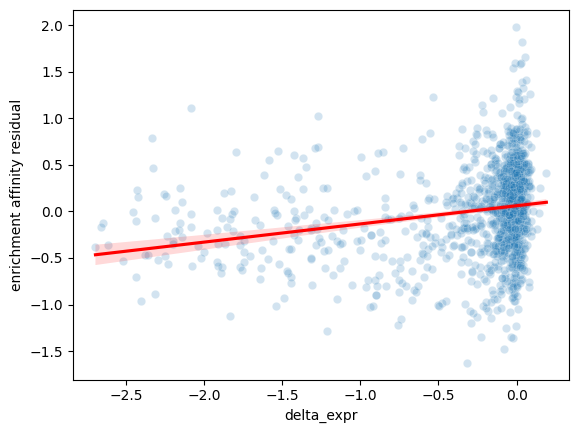

In [7]:
def linear_regression(data, predictor, response):
   """
   Perform linear regression analysis with plots and statistics.
   
   Args:
       data: pandas DataFrame
       predictor: str, column name for independent variable
       response: str, column name for dependent variable
   """
   # Plot
   sns.scatterplot(data=data, x=predictor, y=response, alpha=0.2)
   sns.regplot(data=data, x=predictor, y=response, scatter=False, color='red')
   
   # Regression analysis
   X = data[predictor]
   X = sm.add_constant(X)
   model = sm.OLS(data[response], X).fit()
   print(model.summary().tables[1])


linear_regression(data, 'delta_expr', 'enrichment affinity residual')

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3072      0.017    -18.590      0.000      -0.340      -0.275
delta_expr     0.4919      0.026     19.183      0.000       0.442       0.542


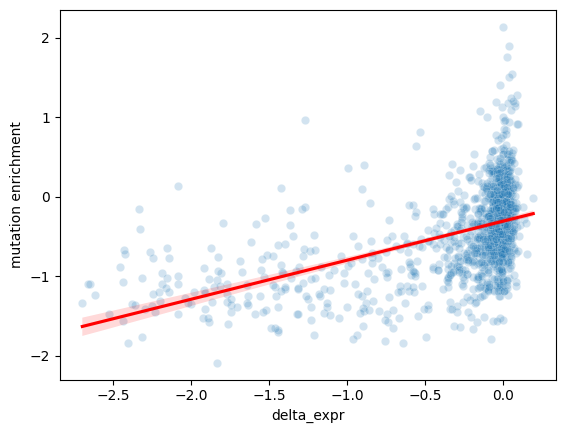

In [8]:
linear_regression(data, 'delta_expr', 'mutation enrichment')

In [9]:
# Slope is ML estimator for Poisson regression using an identity link function.
# Here we set this up for the complete dataset but also use the same formula for the per-timepoint data below.
slope = data["mutation abundance"].sum() / data["mutation rate"].sum()
rate_grid = np.geomspace(1e-4, data["mutation rate"].max(), 100)
predicted_events = slope * data["mutation rate"]
data["mutation enrichment"] = np.log10((.5 + dms_df.query(query_str)["mutation abundance"]) / (.5 + predicted_events))
data["delta_avidity"] = data["delta_bind_CGG"] + data["delta_expr"]

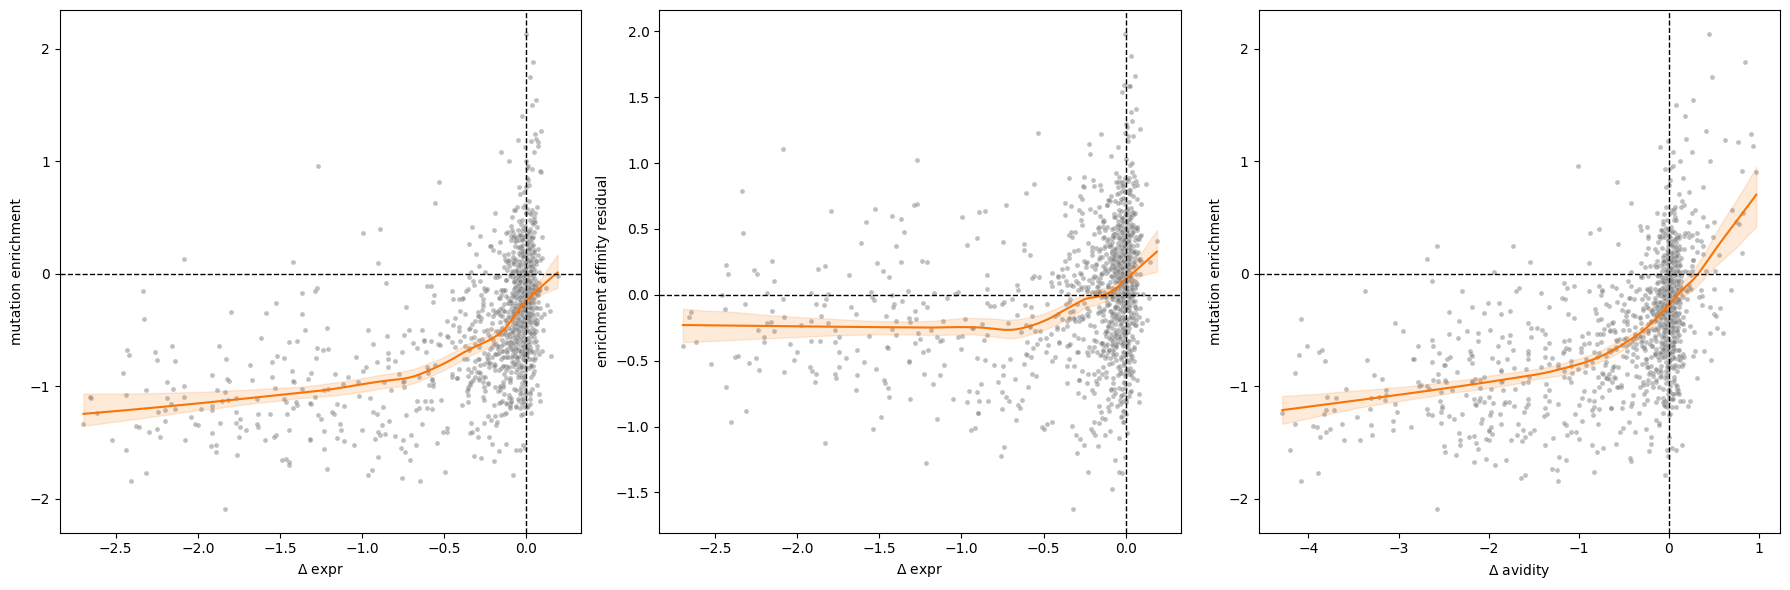

In [10]:
def plot_enrichment_vs_delta(measured_var, outcome_var, ax):
    regplot_lowess_ci(data=data,
            x=f"delta_{measured_var}", y=outcome_var ,
            ci_level=95, n_boot=100,
            scatter_kwargs=dict(s=13, alpha=0.5, color="grey"),
            line_kwargs=dict(color="xkcd:orange"),
            ax=ax,
            )
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.axvline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel(fr"$\Delta$ {measured_var}")
    ax.set_ylabel(outcome_var)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_enrichment_vs_delta("expr", "mutation enrichment", axs[0])
plot_enrichment_vs_delta("expr", "enrichment affinity residual", axs[1])
plot_enrichment_vs_delta("avidity", "mutation enrichment", axs[2])
plt.tight_layout()